# Resubmission Paper 18

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import warnings
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

# Download lexicon (run once locally)
nltk.download('vader_lexicon')

warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nidial\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Access file path
file_path = r"C:\Users\nidial\VS projects\PPG\ChatPaper\University\ChatGPT_Mixed_Itais.xlsx"
df = pd.read_excel(file_path)


### Sentiment analysis

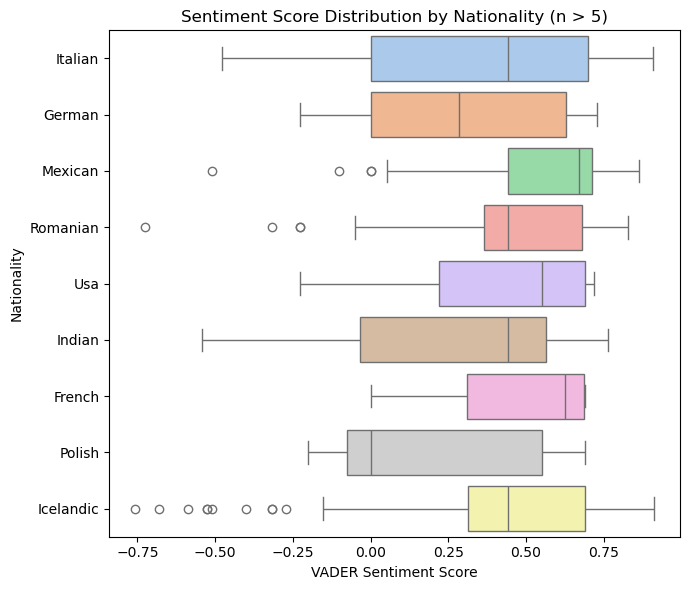

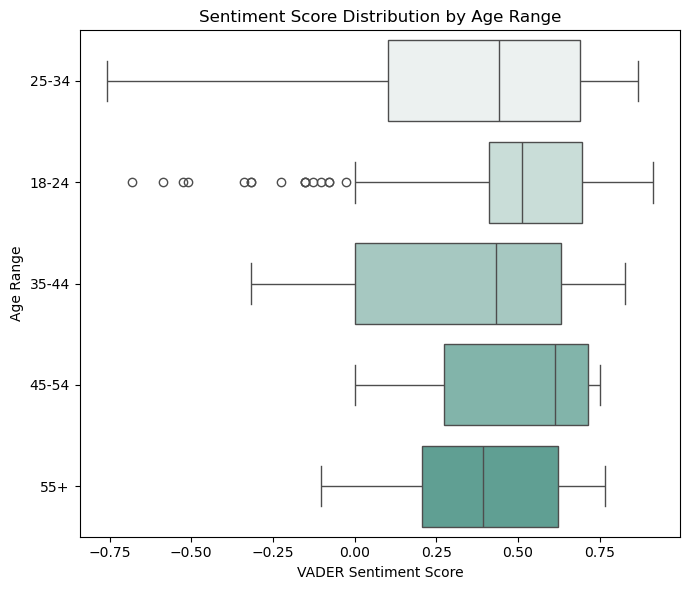

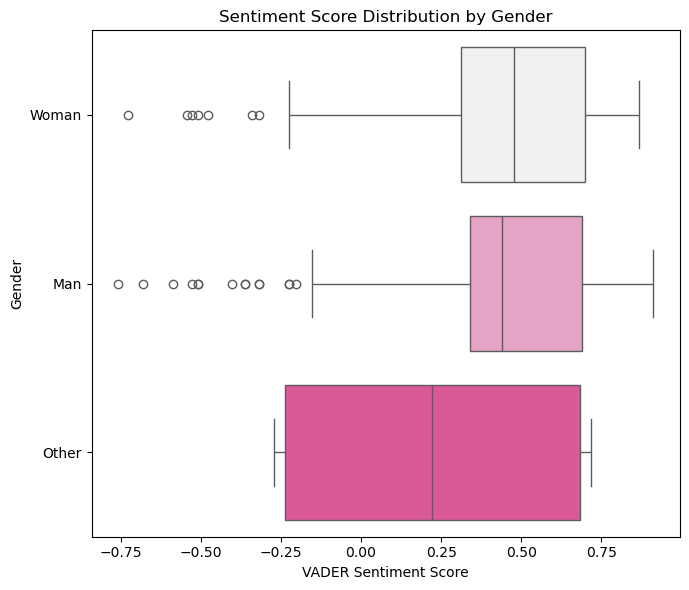

In [3]:

# Data preparation
df_clean = df.dropna(subset=['adj1', 'adj2', 'adj3'])

# Normalize values
df_clean['Nationatily'] = df_clean['Nationatily'].str.strip().str.title()
df_clean['Gender'] = df_clean['Gender'].str.strip().str.title()
df_clean['AgeRange'] = df_clean['AgeRange'].str.strip()

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Sentiment analysis
df_clean['Adj_combined'] = df_clean[['adj1', 'adj2', 'adj3']].agg(' '.join, axis=1)
df_clean['Adj_Sentiment_Score'] = df_clean['Adj_combined'].apply(lambda x: sia.polarity_scores(x)['compound'])

# === PLOT 1: Sentiment by Nationality (only if >5 participants) ===
valid_nats = df_clean['Nationatily'].value_counts()
valid_nats = valid_nats[valid_nats > 5].index
df_nats = df_clean[df_clean['Nationatily'].isin(valid_nats)]

plt.figure(figsize=(7, 6))
sns.boxplot(data=df_nats, x='Adj_Sentiment_Score', y='Nationatily', palette='pastel')
plt.title('Sentiment Score Distribution by Nationality (n > 5)')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Nationality')
plt.tight_layout()
plt.show()

# === PLOT 2: Sentiment by Age Range ===
plt.figure(figsize=(7, 6))
sns.boxplot(data=df_clean, x='Adj_Sentiment_Score', y='AgeRange', palette='light:#5A9')
plt.title('Sentiment Score Distribution by Age Range')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Age Range')
plt.tight_layout()
plt.show()

# === PLOT 3: Sentiment by Gender ===
plt.figure(figsize=(7, 6))
sns.boxplot(data=df_clean, x='Adj_Sentiment_Score', y='Gender', palette='light:#E49')
plt.title('Sentiment Score Distribution by Gender')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Gender')
plt.tight_layout()
plt.show()


In [4]:
# Group sentiment scores by gender
groups = df_clean.groupby('Gender')['Adj_Sentiment_Score'].apply(list)

# Run one-way ANOVA
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA p-value (Gender vs Sentiment Score): {p_value:.4f}")

# By AgeRange (ANOVA)
age_groups = [group['Adj_Sentiment_Score'].dropna() for name, group in df_clean.groupby('AgeRange')]
f_stat, p_age = f_oneway(*age_groups)
print(f"ANOVA p-value (Age Range vs Sentiment): {p_age:.4f}")

# Group by nationality and run ANOVA
nat_groups = df_clean.groupby('Nationatily')['Adj_Sentiment_Score'].apply(list)
f_s, p_v = f_oneway(*nat_groups)
print(f"ANOVA p-value (Nationality vs Sentiment Score): {p_v:.4f}")

ANOVA p-value (Gender vs Sentiment Score): 0.3081
ANOVA p-value (Age Range vs Sentiment): 0.0350
ANOVA p-value (Nationality vs Sentiment Score): 0.0514


#### Regression model for analysing how sentiment scores vary based on the perceived gender, age group, participant gender, and nationality


In [12]:
cols = ['Adj_Sentiment_Score', 'ChatGPT_Gender', 'AgeRange', 'Gender', 'Nationatily']
df_clean = df_clean.dropna(subset=cols).copy()

formula = 'Adj_Sentiment_Score ~ C(ChatGPT_Gender, Treatment(reference="Genderless")) + C(AgeRange) + C(Gender, Treatment(reference = "Man")) + C(Nationatily)'
model_ols = smf.ols(formula, data=df_clean).fit(cov_type='HC3')
print("\nOLS (HC3 robust SEs):\n")
print(model_ols.summary())


OLS (HC3 robust SEs):

                             OLS Regression Results                            
Dep. Variable:     Adj_Sentiment_Score   R-squared:                       0.075
Model:                             OLS   Adj. R-squared:                  0.029
Method:                  Least Squares   F-statistic:                     1.974
Date:                 Sat, 30 Aug 2025   Prob (F-statistic):            0.00900
Time:                         14:36:07   Log-Likelihood:                -125.93
No. Observations:                  402   AIC:                             291.9
Df Residuals:                      382   BIC:                             371.8
Df Model:                           19                                         
Covariance Type:                   HC3                                         
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

#### Results

- R-squared = 0.075 (7.5% of variance explained), adjusted R-squared = 0.029.
- The overall model is statistically significant (p = 0.009), but explanatory power is weak.

No significant differences in sentiment scores between perceived gender, participant gender, or nationality. 

**Age**

Only the 35–44 age group shows a significant negative effect (coef = -0.137, p = 0.023), meaning this group rates ChatGPT less positively than the baseline age group 18–24.



#### Regression model for analysing how sentiment scores vary based on the perceived gender, age group, participant gender, and nationality - Interaction effects

Additional considerations: 
- Analysis includes interaction effects between gender attribution and age (as suggested by the reviewers. )

In [13]:
formula = (
    "Adj_Sentiment_Score ~ "
    "C(ChatGPT_Gender, Treatment(reference='Male ')) * C(AgeRange) "
    "+ C(Gender) + C(Nationatily)"
)
model_ols = smf.ols(formula, data=df_clean).fit(cov_type='HC3')
print("\nOLS (HC3 robust SEs):\n")
print(model_ols.summary())



OLS (HC3 robust SEs):

                             OLS Regression Results                            
Dep. Variable:     Adj_Sentiment_Score   R-squared:                       0.090
Model:                             OLS   Adj. R-squared:                  0.027
Method:                  Least Squares   F-statistic:                     2.398
Date:                 Sat, 30 Aug 2025   Prob (F-statistic):           0.000196
Time:                         14:36:16   Log-Likelihood:                -122.72
No. Observations:                  402   AIC:                             299.4
Df Residuals:                      375   BIC:                             407.4
Df Model:                           26                                         
Covariance Type:                   HC3                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

#### Results: 
- The R-squared is 0.09, meaning the model explains about 9% of the variation in sentiment scores. The adjusted R-squared is lower (0.027), indicating weak explanatory power.
- The overall model is statistically significant (F-statistic p-value ≈ 0.0002), but most individual predictors are not.


**Age**

The only significant effect is for participants aged 45–54, who have a higher sentiment score (coef = 0.294, p = 0.000).

**Age x Gender perception**

The interaction between "Female" attribution and age 45–54 is also significant (coef = -0.328, p = 0.012), indicating that assigning ChatGPT as "Female" in this age group is associated with lower sentiment scores.

## Linear regression model for satisfaction level 

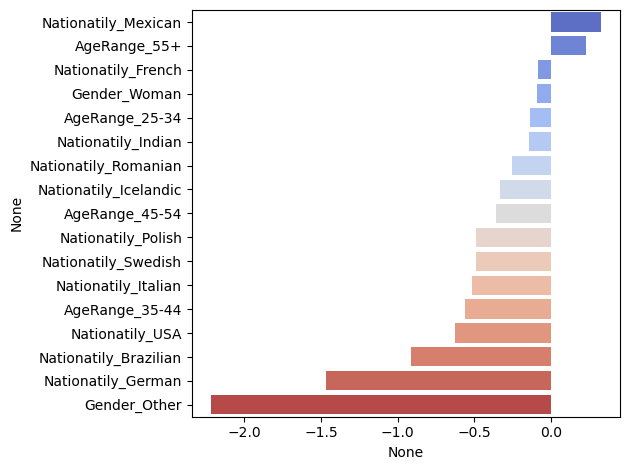

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_excel('ChatGPT_Mixed_Itais.xlsx')
df_clean = df.dropna(subset=['AgeRange', 'Gender', 'Nationatily', 'adj1', 'adj2', 'adj3', 'Reason', 'Satisfaction', 'ChatGPT_Gender'])

# Encoding
X = pd.get_dummies(df_clean[['AgeRange', 'Gender', 'Nationatily']], drop_first=True)
y_satisfaction = df_clean['Satisfaction']

# Regression for Satisfaction
lin_reg = LinearRegression().fit(X, y_satisfaction)
importance_reg = pd.Series(lin_reg.coef_, index=X.columns).sort_values(ascending=False)

sns.barplot(x=importance_reg, y=importance_reg.index, palette='coolwarm')
axes[1].set_title('Top Features Influencing Satisfaction', fontsize=14)
axes[1].set_xlabel('Coefficient (Importance)', fontsize=12)
axes[1].set_ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.show()

Implementing regression model with statmodels to review significance scores:

In [ ]:
import statsmodels.api as sm

# Add intercept term
X_sm = sm.add_constant(X.astype(int))

# Fit regression model
lin_model = sm.OLS(y_satisfaction, X_sm).fit()

# Get full regression summary
print(lin_model.summary())

# Get coefficients as a Series (like sklearn’s style)
importance_reg = pd.Series(lin_model.params, index=X_sm.columns).sort_values(ascending=False)
print(importance_reg)


                            OLS Regression Results                            
Dep. Variable:           Satisfaction   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     2.571
Date:              lau., 30 ágú. 2025   Prob (F-statistic):           0.000630
Time:                        13:10:53   Log-Likelihood:                -731.03
No. Observations:                 401   AIC:                             1498.
Df Residuals:                     383   BIC:                             1570.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     7.75

### Results

The model is statistically significant but with a weak explanatory power. These results show that in this sample the only reliable predictors of satisfaction level are (1) AgeRange_35–44 with a score of -0.56 (p = 0.039), meaning that people aged 35–44 report ~0.56 points lower satisfaction level compared to the baseline age group 18–24, and (2) gender_Other with a score of -2.22 (p = 0.006),meaning that participants identifying as "Other" have ~2.2 points lower satisfaction level than the baseline male gender.

## Logistic Regression model for gender perception

Additional considerations: 
- Model is implemented with the redefined target as: 1~Gendered (Assigned 'Male' or 'Female') and 0~Genderless.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_excel('ChatGPT_Mixed_Itais.xlsx')
df_clean = df.dropna(subset=['AgeRange', 'Gender', 'Nationatily', 'adj1', 'adj2', 'adj3', 'Reason', 'Satisfaction', 'ChatGPT_Gender'])

df_clean['ChatGPT_Gender'] = df_clean['ChatGPT_Gender'].replace({'Male ': 'Gendered', 'Female': 'Gendered'})

# Binary target: 1 if "Gendered", 0 otherwise
y_gender_bin = (df_clean['ChatGPT_Gender'] == 'Gendered').astype(int)

# Fit logistic regression
log_reg = LogisticRegression(max_iter=1000).fit(X, y_gender_bin)
importance_class = pd.Series(log_reg.coef_[0], index=X.columns).sort_values(ascending=False)

accuracy = log_reg.score(X, y_gender_bin)
print(f"Logistic Regression Accuracy (AI Gender classification): {accuracy:.3f}")

Logistic Regression Accuracy (AI Gender classification): 0.731


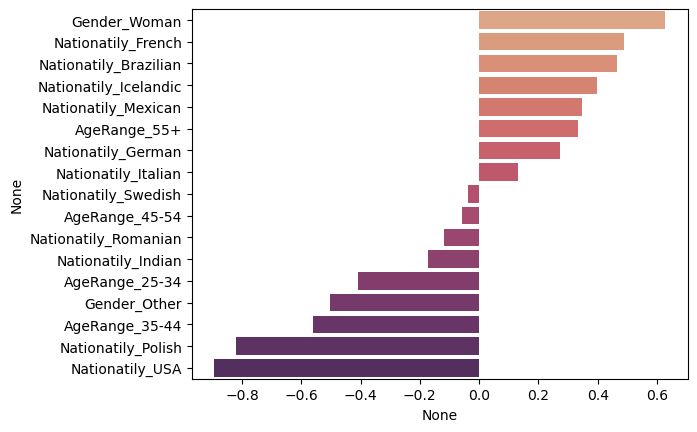

In [ ]:
sns.barplot(x=importance_class, y=importance_class.index, palette='flare')
axes[0].set_title('Top Features Influencing AI Gender', fontsize=14)
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_ylabel('Feature', fontsize=12)

plt.show()

Implementing logit model with statmodels to review significance scores

In [ ]:
import statsmodels.api as sm

# Add a constant term to predictors
X_sm = sm.add_constant(X.astype(int))

# Fit logistic regression model
logit_model = sm.Logit(y_gender_bin, X_sm).fit_regularized(method='l1', alpha=1.0) # We use L1 regularization to handle sparsity

# Summary of the logistic regression model
print(logit_model.summary())

#  odds ratios and confidence intervals
params = logit_model.params
conf = logit_model.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
odds_ratios = pd.DataFrame(np.exp(conf))
print(odds_ratios.sort_values("OR", ascending=False))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5697396925743218
            Iterations: 80
            Function evaluations: 81
            Gradient evaluations: 80
                           Logit Regression Results                           
Dep. Variable:         ChatGPT_Gender   No. Observations:                  401
Model:                          Logit   Df Residuals:                      392
Method:                           MLE   Df Model:                            8
Date:              lau., 30 ágú. 2025   Pseudo R-squ.:                 0.04203
Time:                        12:51:35   Log-Likelihood:                -223.80
converged:                       True   LL-Null:                       -233.62
Covariance Type:            nonrobust   LLR p-value:                   0.01179
                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

### Results: 

L1 regularisation forces sparse predictors to zero, thus dropping them from the model. From the remaining coeficients, p-values and confidence intervals, it can be observed that the only significant value corresponds to *Gender_Woman*. 

This results can be interpreted as: Being a woman increases the odds of `ChatGPT_gender=1` (i.e. assigining a gender to ChatGPT) by ~78% (From the odds ratio table). 

### Multinomial logistic regression for gender perception based on age group, participant's gender, sentiment score, and satisfaction level. 

Additional considerations:

- Gender 'Other' category dropped
- Age groups "45-55" and "55+" merged into "45+"

In [ ]:
import pandas as pd
import statsmodels.api as sm
import patsy

# --- Drop sparse gender category ---
df = df[df["Gender"] != "Other"]

# --- Collapse sparse age groups into 45+ ---
df["AgeRange"] = df["AgeRange"].replace({"45-54": "45+", "55+": "45+"})

# --- Ensure categorical types ---
df["ChatGPT_Gender"] = df["ChatGPT_Gender"].astype("category")
df["AgeRange"] = df["AgeRange"].astype("category")
df["Gender"] = df["Gender"].astype("category")

# Define model 
y, X = patsy.dmatrices(
    "ChatGPT_Gender ~ C(AgeRange) + C(Gender) + Adj_Sentiment_Score + Satisfaction",
    df,
    return_type="dataframe"
)

# Convert y to flat vector
y = df["ChatGPT_Gender"].cat.codes  # 0=Female,1=Genderless,2=Male 


# --- 1) Ensure X has a *flat*, hashable column index and no names ---
if isinstance(X.columns, pd.MultiIndex):
    # join tuple levels into strings
    X.columns = ["__".join(map(str, tup)) for tup in X.columns]
X.columns = [str(c) for c in X.columns]   # force plain strings
X.columns.name = None                     # remove column index name, if any

# --- 2) Ensure X index is simple (no MultiIndex with list-named levels) ---
if isinstance(X.index, pd.MultiIndex):
    X.index = X.index.to_flat_index()
X.index.name = None

# --- 3) Align y to X and make y a plain 1-D int array ---
y = y.loc[X.index]
y = np.asarray(y, dtype=int)

# --- 4) Safety checks ---
assert y.ndim == 1, "y must be 1-D"
assert not np.isnan(y).any(), "y contains NaN"
assert X.shape[0] == y.shape[0], "X and y must have same number of rows"
# statsmodels wants purely numeric exog:
assert all(np.issubdtype(dt, np.number) for dt in X.dtypes), "X has non-numeric columns"

# --- 5) Fit MNLogit (now should work) ---
mod = sm.MNLogit(y, X)
res = mod.fit(method="newton", maxiter=200, disp=False, cov_type="HC3")
print(res.summary())


# --- 5) Tidy Relative Risk Ratios (RRR = exp(coef)) ---
def tidy_rrr(result):
    """
    Build a tidy table of Relative Risk Ratios (RRR = exp(coef)) with CIs.
    Works regardless of whether result.params is a DataFrame with a MultiIndex
    or something flatter. Returns a regular DataFrame (no special index names).
    """
    import numpy as np
    import pandas as pd
    from scipy.stats import norm

    params = result.params
    bse = result.bse

    # Ensure DataFrames for consistent stacking
    if isinstance(params, pd.Series):
        params = params.to_frame("coef").T  # make it 1-row DataFrame
        bse = bse.to_frame("SE").T

    coef_long = params.stack().rename("coef")
    se_long   = bse.stack().rename("SE")

    # Align
    long = pd.concat([coef_long, se_long], axis=1)

    # Stats
    long["z"] = long["coef"] / long["SE"]
    long["p"] = 2 * (1 - norm.cdf(np.abs(long["z"])))
    long["RRR"] = np.exp(long["coef"])
    long["RRR_ci_lo"] = np.exp(long["coef"] - 1.96 * long["SE"])
    long["RRR_ci_hi"] = np.exp(long["coef"] + 1.96 * long["SE"])

    # If it’s a MultiIndex, set level names safely; otherwise don’t touch names
    if isinstance(long.index, pd.MultiIndex):
        # Use a TUPLE of strings (hashable) or call set_names with a list of strings
        long.index = long.index.set_names(("Outcome_vs_Baseline", "Term"))

    # Return a flat DataFrame for easy printing/CSV
    return long.reset_index()

print("\nRRR table (HC3):")
print(tidy_rrr(res).round(3))

# --- 6) Average marginal effects (easier to interpret) ---
mfx = res.get_margeff(at='overall', method='dydx')
print("\nAverage marginal effects (HC3):")
print(mfx.summary())


                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  398
Model:                        MNLogit   Df Residuals:                      384
Method:                           MLE   Df Model:                           12
Date:                Sat, 30 Aug 2025   Pseudo R-squ.:                 0.02931
Time:                        13:53:00   Log-Likelihood:                -295.81
converged:                       True   LL-Null:                       -304.74
Covariance Type:                  HC3   LLR p-value:                    0.1200
                 y=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.9964      0.766     -2.605      0.009      -3.499      -0.494
C(AgeRange)[T.25-34]    -0.7967      0.327     -2.440      0.015      -1.437      -0.157
C(AgeRange)[

#### Results

- The pseudo R² is low (0.029), meaning the model explains only a small portion of the variation in gender attribution.
- The likelihood ratio test p-value (0.12) indicates the predictors are not jointly significant at the 0.05 level.

Neither sentiment score nor satisfaction are significant predictors of perceived ChatGPT's gender. However gender attribution to ChatGPT is mainly influenced by participant age and gender:

**Age**

Participants aged 25–34 and 35–44 are significantly less likely than the reference group (18–24) to assign ChatGPT as Genderless (y=1), consistently with the RRR values for these categories. 

**Gender**

Women are significantly more likely than men to assign ChatGPT as Genderless or Male (positive coefficients for y=1 and y=2, p ≈ 0.04).